# Features

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import math
from geopy.distance import geodesic
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import seaborn as sns
from sklearn.feature_selection import SelectKBest

In [2]:
# Set max rows and columns display
pd.set_option("display.max_columns", None)

## Load Datasets

In [3]:
# read in csv file
train = pd.read_csv('./data/train_cleaned.csv')
weather = pd.read_csv('./data/weather_cleaned.csv')

In [4]:
print(train.shape)
train.head(2)

(10506, 15)


,date,address,species,block,trap,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent,year,month,week,day,day_of_week
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,T002,41.95469,-87.800991,9,1,0,2007,5,22,29,1
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,T002,41.95469,-87.800991,9,1,0,2007,5,22,29,1


In [5]:
print(weather.shape)
weather.head(2)

(2944, 22)


,station,date,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,sunrise,sunset,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,week,day,day_of_week
0,1,2007-05-01,83,50,67,51,56,0,2,448,1849,0.0,29.10,29.82,1.7,27,9.2,2007,5,18,1,1
1,2,2007-05-01,84,52,68,51,57,0,3,448,1849,0.0,29.18,29.82,2.7,25,9.6,2007,5,18,1,1


In [6]:
# remove unnecessary columns
weather.drop(['year','month','week','day','day_of_week'], axis=1, inplace=True)

## Feature Engineering

### Relevant Mosquito Species
It was observed during EDA that CULEX RESTUANS and CULEX PIPIENS were the only two species that acted as vectors for the West Nile Virus. The other 3 species had a poor number of observations in the test set and will as such be classified as 'others'.

                        nummosquitos  wnvpresent
species                                         
CULEX ERRATICUS                    7           0
CULEX PIPIENS                  44671         240
CULEX PIPIENS/RESTUANS         66268         262
CULEX RESTUANS                 23431          49
CULEX SALINARIUS                 145           0
CULEX TARSALIS                     7           0
CULEX TERRITANS                  510           0
 


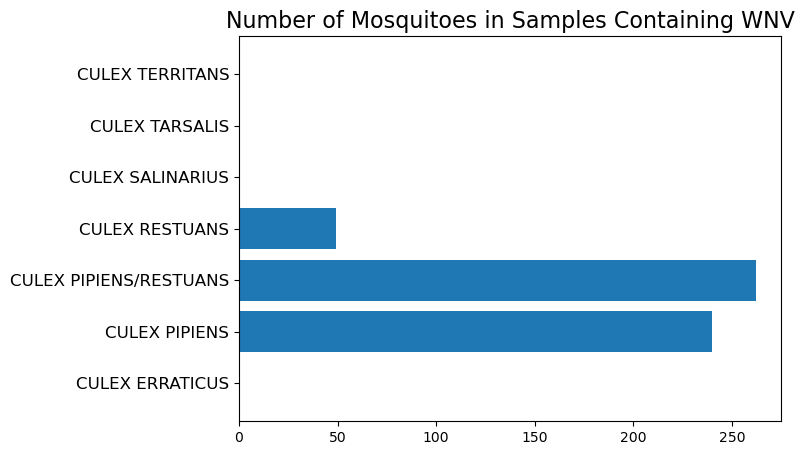

In [7]:
mos_wnv = train[['species', 'nummosquitos', 'wnvpresent']].groupby(by='species').sum()
print(mos_wnv)
print(' ')
mos_wnv.reset_index(inplace=True)
plt.figure(figsize=(7,5))
plt.barh(mos_wnv['species'], mos_wnv['wnvpresent'])
plt.title('Number of Mosquitoes in Samples Containing WNV', fontsize=16)
plt.yticks(fontsize=12)
plt.show()

In [8]:
# lump species apart from restuans or pipiens into 'others'
train['species']=train['species'].replace({'CULEX SALINARIUS': 'others', 'CULEX TERRITANS': 'others', 'CULEX TARSALIS': 'others', 'CULEX ERRATICUS': 'others'})
train.groupby('species')['species'].count()

species
CULEX PIPIENS             2699
CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
others                     315
Name: species, dtype: int64

### Favourable Breeding Temperature
Culex mosquitoes thrive in warm and wet environments, with a favourable breeding temperature of above 60 degrees fahrenheit.

In [9]:
weather['favourablebreedingtemp'] = 0
weather['favourablebreedingtemp'].loc[weather['tavg'] > 60] = 1

C:\Users\liamt\AppData\Local\Temp\ipykernel_16148\1684448067.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['favourablebreedingtemp'].loc[weather['tavg'] > 60] = 1


### Relative Humidity
Culex mosquitoes thrive in warm and wet environments. Relative humidity is a measure of the overall 'wetness' of air.

In [10]:
def celsius(tempf):
    tempc = ((tempf - 32) * 5.0)/9.0
    return float(tempc)

def r_humid(row):
    row['r_humid'] = round(100*(math.exp((17.625*row['dewpointc'])/(243.04+row['dewpointc'])) \
                          / math.exp((17.625*row['tavgc'])/(243.04+row['tavgc']))))
    return row

In [11]:
# create columns to be used for calculation
weather['tavgc'] = weather['tavg'].apply(celsius)
weather['tminc'] = weather['tmin'].apply(celsius)
weather['tmaxc'] = weather['tmax'].apply(celsius)
weather['dewpointc'] = weather['dewpoint'].apply(celsius)

In [12]:
# create relative humidity column
weather = weather.apply(r_humid, axis=1)

# drop columns used for calculation of relative humidity
weather = weather.drop(columns=['tavgc', 'tminc', 'tmaxc', 'dewpointc'])

### Day/Night Length
Culex mosquitoes are night biters, active from dusk till dawn.

In [13]:
weather['daylength_hour'] = round((weather['sunset'] - weather['sunrise'])/100)

In [14]:
weather['nightlength_hour'] = round(24 - weather['daylength_hour'])

### Accounting for Mosquito Lifecycle
Culex mosquitos take around 7-10 days to hatch and fully develop into biting adults<a href="https://www.cdc.gov/mosquitoes/about/life-cycles/culex.html"><sup>1</sup></a>. Lagged weather features might as such be indicative of mosquito activity due to favorable breeding conditions 7-10 days prior. We will be taking weather features from 9 days back for this.

In [15]:
def weatherlag(df, lag):  # df - dataframe, lag - list of numbers defining lagged values. Builds lagged weather features 
    new_dict={}
    for col_name in df:
        new_dict[col_name]=df[col_name]
        # create lagged Series
        for l in lag:
            if col_name!='date' and col_name!='station':
                new_dict['%s_lag%d' %(col_name,l)]=df[col_name].shift(l*2)
    res=pd.DataFrame(new_dict,index=df.index)
    return res

In [16]:
weather = weatherlag(weather, [9]).dropna()
weather

,station,date,tmax,tmax_lag9,tmin,tmin_lag9,tavg,tavg_lag9,dewpoint,dewpoint_lag9,wetbulb,wetbulb_lag9,heat,heat_lag9,cool,cool_lag9,sunrise,sunrise_lag9,sunset,sunset_lag9,preciptotal,preciptotal_lag9,stnpressure,stnpressure_lag9,sealevel,sealevel_lag9,resultspeed,resultspeed_lag9,resultdir,resultdir_lag9,avgspeed,avgspeed_lag9,favourablebreedingtemp,favourablebreedingtemp_lag9,r_humid,r_humid_lag9,daylength_hour,daylength_hour_lag9,nightlength_hour,nightlength_hour_lag9
18,1,2007-05-10,84,83.0,56,50.0,70,67.0,52,51.0,60,56.0,0,0.0,5,2.0,437,448.0,1859,1849.0,0.0000,0.0,29.20,29.10,29.92,29.82,0.7,1.7,17,27.0,4.1,9.2,1,1.0,53,56.0,14.0,14.0,10.0,10.0
19,2,2007-05-10,83,84.0,59,52.0,71,68.0,52,51.0,61,57.0,0,0.0,6,3.0,437,448.0,1859,1849.0,0.0000,0.0,29.26,29.18,29.91,29.82,2.0,2.7,9,25.0,3.9,9.6,1,1.0,51,55.0,14.0,14.0,10.0,10.0
20,1,2007-05-11,70,59.0,51,42.0,61,51.0,42,42.0,51,47.0,4,14.0,0,0.0,436,447.0,1860,1850.0,0.0000,0.0,29.33,29.38,30.04,30.09,11.3,13.0,3,4.0,12.9,13.4,1,0.0,50,71.0,14.0,14.0,10.0,10.0
21,2,2007-05-11,73,60.0,49,43.0,61,52.0,44,42.0,51,47.0,4,13.0,0,0.0,436,447.0,1860,1850.0,0.0000,0.0,29.39,29.44,30.03,30.08,11.7,13.3,36,2.0,12.8,13.4,1,0.0,54,69.0,14.0,14.0,10.0,10.0
22,1,2007-05-12,64,66.0,46,46.0,55,56.0,36,40.0,46,48.0,10,9.0,0,0.0,435,446.0,1901,1851.0,0.0000,0.0,29.49,29.39,30.20,30.12,12.4,11.7,3,7.0,12.9,11.9,0,0.0,49,55.0,15.0,14.0,9.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2939,2,2014-10-29,49,66.0,40,50.0,45,58.0,34,46.0,42,51.0,20,7.0,0,0.0,620,610.0,1650,1703.0,0.0000,0.0,29.42,29.23,30.07,29.90,8.5,4.9,29,32.0,9.0,9.1,0,0.0,65,64.0,10.0,11.0,14.0,13.0
2940,1,2014-10-30,51,53.0,32,45.0,42,49.0,34,39.0,40,44.0,23,16.0,0,0.0,622,611.0,1649,1701.0,0.0000,0.0,29.34,29.46,30.09,30.16,5.1,10.8,24,1.0,5.5,11.4,0,0.0,73,68.0,10.0,11.0,14.0,13.0
2941,2,2014-10-30,53,54.0,37,49.0,45,52.0,35,41.0,42,46.0,20,13.0,0,0.0,622,611.0,1649,1701.0,0.1472,0.0,29.41,29.51,30.10,30.15,5.9,11.0,23,36.0,6.5,11.6,0,0.0,68,66.0,10.0,11.0,14.0,13.0
2942,1,2014-10-31,47,56.0,33,35.0,40,46.0,25,38.0,33,43.0,25,19.0,0,0.0,623,612.0,1647,1660.0,0.0300,0.0,29.49,29.56,30.20,30.30,22.6,2.9,34,8.0,22.9,4.8,0,0.0,55,73.0,10.0,10.0,14.0,14.0


## Matching Weather Data from Closest Station
The longitude and latitude of the 2 weather stations from which weather data was collected is provided in the Kaggle data description. Using Geopy to get the geodesic distance from each station, we are able to match the appropriate weather features from the closest station to each observation.

In [17]:
def distance(row, stn_lat, stn_long): 
    add1 = (row['latitude'], row['longitude']) 
    add2 = (row[stn_lat], row[stn_long]) 
    try: 
        return (geodesic(add1, add2).miles) 
    except: 
        return np.nan

In [18]:
def closest_station(df): # identify the closest weather station
    indicator = np.less_equal(df.stn_dist1.values, df.stn_dist2.values) # determine which station is the closest
    st = np.ones(df.shape[0])
    st[indicator==0]=2
    df['station']=st    # obtain station identifier for each row 
    df.drop(['stn_dist1', 'stn_dist2', 'lat1', 'lat2', 'lon1', 'lon2' ], axis=1, inplace=True)
    return df

In [19]:
train['lat1']=41.995   # latitude of 1st station
train['lat2']=41.786   # latitude of 2nd station
train['lon1']=-87.933  # longitude of 1st station
train['lon2']=-87.752  # longitude of 2nd station

In [20]:
train['stn_dist1'] = train.apply(lambda row: distance(row, 'lat1', 'lon1'), axis = 1)
train['stn_dist2'] = train.apply(lambda row: distance(row, 'lat2', 'lon2'), axis = 1)

In [21]:
closest_station(train)

,date,address,species,block,trap,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent,year,month,week,day,day_of_week,station
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,T002,41.954690,-87.800991,9,1,0,2007,5,22,29,1,1.0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,T002,41.954690,-87.800991,9,1,0,2007,5,22,29,1,1.0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,T007,41.994991,-87.769279,9,1,0,2007,5,22,29,1,1.0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,T015,41.974089,-87.824812,8,1,0,2007,5,22,29,1,1.0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,T015,41.974089,-87.824812,8,4,0,2007,5,22,29,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10501,2013-09-26,"5100 West 72nd Street, Chicago, IL 60638, USA",CULEX PIPIENS/RESTUANS,51,T035,41.763733,-87.742302,8,6,1,2013,9,39,26,3,2.0
10502,2013-09-26,"5800 North Ridge Avenue, Chicago, IL 60660, USA",CULEX PIPIENS/RESTUANS,58,T231,41.987280,-87.666066,8,5,0,2013,9,39,26,3,1.0
10503,2013-09-26,"1700 North Ashland Avenue, Chicago, IL 60622, USA",CULEX PIPIENS/RESTUANS,17,T232,41.912563,-87.668055,9,1,0,2013,9,39,26,3,2.0
10504,2013-09-26,"7100 North Harlem Avenue, Chicago, IL 60631, USA",CULEX PIPIENS/RESTUANS,71,T233,42.009876,-87.807277,9,5,0,2013,9,39,26,3,1.0


In [22]:
# merge train and weather data
df = train.merge(weather, how='left', on=['date', 'station'])

In [23]:
df.head()

,date,address,species,block,trap,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent,year,month,week,day,day_of_week,station,tmax,tmax_lag9,tmin,tmin_lag9,tavg,tavg_lag9,dewpoint,dewpoint_lag9,wetbulb,wetbulb_lag9,heat,heat_lag9,cool,cool_lag9,sunrise,sunrise_lag9,sunset,sunset_lag9,preciptotal,preciptotal_lag9,stnpressure,stnpressure_lag9,sealevel,sealevel_lag9,resultspeed,resultspeed_lag9,resultdir,resultdir_lag9,avgspeed,avgspeed_lag9,favourablebreedingtemp,favourablebreedingtemp_lag9,r_humid,r_humid_lag9,daylength_hour,daylength_hour_lag9,nightlength_hour,nightlength_hour_lag9
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,T002,41.954690,-87.800991,9,1,0,2007,5,22,29,1,1.0,88,69.0,60,43.0,74,56.0,58,40.0,65,44.0,0,9.0,9,0.0,421,427.0,1917,1909.0,0.0,0.07,29.39,29.38,30.11,30.11,5.8,10.4,18,4.0,6.5,10.7,1,0.0,57,55.0,15.0,15.0,9.0,9.0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,T002,41.954690,-87.800991,9,1,0,2007,5,22,29,1,1.0,88,69.0,60,43.0,74,56.0,58,40.0,65,44.0,0,9.0,9,0.0,421,427.0,1917,1909.0,0.0,0.07,29.39,29.38,30.11,30.11,5.8,10.4,18,4.0,6.5,10.7,1,0.0,57,55.0,15.0,15.0,9.0,9.0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,T007,41.994991,-87.769279,9,1,0,2007,5,22,29,1,1.0,88,69.0,60,43.0,74,56.0,58,40.0,65,44.0,0,9.0,9,0.0,421,427.0,1917,1909.0,0.0,0.07,29.39,29.38,30.11,30.11,5.8,10.4,18,4.0,6.5,10.7,1,0.0,57,55.0,15.0,15.0,9.0,9.0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,T015,41.974089,-87.824812,8,1,0,2007,5,22,29,1,1.0,88,69.0,60,43.0,74,56.0,58,40.0,65,44.0,0,9.0,9,0.0,421,427.0,1917,1909.0,0.0,0.07,29.39,29.38,30.11,30.11,5.8,10.4,18,4.0,6.5,10.7,1,0.0,57,55.0,15.0,15.0,9.0,9.0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,T015,41.974089,-87.824812,8,4,0,2007,5,22,29,1,1.0,88,69.0,60,43.0,74,56.0,58,40.0,65,44.0,0,9.0,9,0.0,421,427.0,1917,1909.0,0.0,0.07,29.39,29.38,30.11,30.11,5.8,10.4,18,4.0,6.5,10.7,1,0.0,57,55.0,15.0,15.0,9.0,9.0


## Preliminary Feature Elimination
the following features are no longer required:
Location features are accounted for by traps and latitude/longitude. Number of mosquitos not present in test dataset and is thus not of much use. Station column was previously already used to match weather data. 

In [24]:
df.drop(['date','address','block','addressaccuracy','nummosquitos','day_of_week','station'], axis=1, inplace=True)

In [25]:
df.shape

(10506, 47)

## One Hot Encoding
Categorical features will need to be converted into dummy variables before they can be processed by machine learning models

In [26]:
# define list of categorical features
df_cat = list(df.select_dtypes(include=['object']).columns)
df_cat

['species', 'trap']

In [27]:
# Use OneHotEncoder
# instantiate the OHE
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

# fit OHE to features
ohe.fit(df[df_cat])

# create dummy array
transformed = ohe.transform(df[df_cat])

# input column names
column_name = ohe.get_feature_names_out(df_cat)

# rebuild dataframe and drop redundant columns
df = pd.concat([df, pd.DataFrame(transformed, columns=column_name)], axis=1)
df.drop(df_cat, axis=1, inplace=True)
df.head()

,latitude,longitude,wnvpresent,year,month,week,day,tmax,tmax_lag9,tmin,tmin_lag9,tavg,tavg_lag9,dewpoint,dewpoint_lag9,wetbulb,wetbulb_lag9,heat,heat_lag9,cool,cool_lag9,sunrise,sunrise_lag9,sunset,sunset_lag9,preciptotal,preciptotal_lag9,stnpressure,stnpressure_lag9,sealevel,sealevel_lag9,resultspeed,resultspeed_lag9,resultdir,resultdir_lag9,avgspeed,avgspeed_lag9,favourablebreedingtemp,favourablebreedingtemp_lag9,r_humid,r_humid_lag9,daylength_hour,daylength_hour_lag9,nightlength_hour,nightlength_hour_lag9,species_CULEX PIPIENS,species_CULEX PIPIENS/RESTUANS,species_CULEX RESTUANS,species_others,trap_T001,trap_T002,trap_T003,trap_T004,trap_T005,trap_T006,trap_T007,trap_T008,trap_T009,trap_T011,trap_T012,trap_T013,trap_T014,trap_T015,trap_T016,trap_T017,trap_T018,trap_T019,trap_T025,trap_T027,trap_T028,trap_T030,trap_T031,trap_T033,trap_T034,trap_T035,trap_T036,trap_T037,trap_T039,trap_T040,trap_T043,trap_T044,trap_T045,trap_T046,trap_T047,trap_T048,trap_T049,trap_T050,trap_T051,trap_T054,trap_T054C,trap_T060,trap_T061,trap_T062,trap_T063,trap_T065,trap_T066,trap_T067,trap_T069,trap_T070,trap_T071,trap_T072,trap_T073,trap_T074,trap_T075,trap_T076,trap_T077,trap_T078,trap_T079,trap_T080,trap_T081,trap_T082,trap_T083,trap_T084,trap_T085,trap_T086,trap_T088,trap_T089,trap_T090,trap_T091,trap_T092,trap_T094,trap_T094B,trap_T095,trap_T096,trap_T097,trap_T099,trap_T100,trap_T102,trap_T103,trap_T107,trap_T114,trap_T115,trap_T128,trap_T129,trap_T135,trap_T138,trap_T141,trap_T142,trap_T143,trap_T144,trap_T145,trap_T146,trap_T147,trap_T148,trap_T149,trap_T150,trap_T151,trap_T152,trap_T153,trap_T154,trap_T155,trap_T156,trap_T157,trap_T158,trap_T159,trap_T160,trap_T161,trap_T162,trap_T200,trap_T206,trap_T209,trap_T212,trap_T215,trap_T218,trap_T219,trap_T220,trap_T221,trap_T222,trap_T223,trap_T224,trap_T225,trap_T226,trap_T227,trap_T228,trap_T229,trap_T230,trap_T231,trap_T232,trap_T233,trap_T235,trap_T236,trap_T237,trap_T238,trap_T900,trap_T903
0,41.954690,-87.800991,0,2007,5,22,29,88,69.0,60,43.0,74,56.0,58,40.0,65,44.0,0,9.0,9,0.0,421,427.0,1917,1909.0,0.0,0.07,29.39,29.38,30.11,30.11,5.8,10.4,18,4.0,6.5,10.7,1,0.0,57,55.0,15.0,15.0,9.0,9.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,41.954690,-87.800991,0,2007,5,22,29,88,69.0,60,43.0,74,56.0,58,40.0,65,44.0,0,9.0,9,0.0,421,427.0,1917,1909.0,0.0,0.07,29.39,29.38,30.11,30.11,5.8,10.4,18,4.0,6.5,10.7,1,0.0,57,55.0,15.0,15.0,9.0,9.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,41.994991,-87.769279,0,2007,5,22,29,88,69.0,60,43.0,74,56.0,58,40.0,65,44.0,0,9.0,9,0.0,421,427.0,1917,1909.0,0.0,0.07,29.39,29.38,30.11,30.11,5.8,10.4,18,4.0,6.5,10.7,1,0.0,57,55.0,15.0,15.0,9.0,9.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [28]:
df.to_csv('./data/feature_selected.csv',index=False)

## Prepping Test Dataset
The same transformations applied on the train dataset will be applied on the test dataset so that predictions can be made later.

In [29]:
# read in the test dataset
test = pd.read_csv('./data/test_cleaned.csv')

In [30]:
# lump species apart from restuans or pipiens into 'others'; # 'UNSPECIFIED CULEX'
test['species']=test['species'].replace({'CULEX SALINARIUS': 'others', 'CULEX TERRITANS': 'others', 'CULEX TARSALIS': 'others', 'CULEX ERRATICUS': 'others', 'UNSPECIFIED CULEX': 'CULEX PIPIENS'})
test.groupby('species')['species'].count()

species
CULEX PIPIENS             28866
CULEX PIPIENS/RESTUANS    15359
CULEX RESTUANS            14670
others                    57398
Name: species, dtype: int64

In [31]:
# match weather features by station
test['lat1']=41.995   # latitude of 1st station
test['lat2']=41.786   # latitude of 2nd station
test['lon1']=-87.933  # longitude of 1st station
test['lon2']=-87.752  # longitude of 2nd station

In [32]:
test['stn_dist1'] = test.apply(lambda row: distance(row, 'lat1', 'lon1'), axis = 1)
test['stn_dist2'] = test.apply(lambda row: distance(row, 'lat2', 'lon2'), axis = 1)

In [33]:
test = closest_station(test)

In [34]:
test = test.merge(weather, how='left', on=['date', 'station'])

In [35]:
# drop unnecessary columns
test.drop(['date','address','block','addressaccuracy','day_of_week','station'], axis=1, inplace=True)

In [36]:
# quick check
test.head()

,id,species,trap,latitude,longitude,year,month,week,day,tmax,tmax_lag9,tmin,tmin_lag9,tavg,tavg_lag9,dewpoint,dewpoint_lag9,wetbulb,wetbulb_lag9,heat,heat_lag9,cool,cool_lag9,sunrise,sunrise_lag9,sunset,sunset_lag9,preciptotal,preciptotal_lag9,stnpressure,stnpressure_lag9,sealevel,sealevel_lag9,resultspeed,resultspeed_lag9,resultdir,resultdir_lag9,avgspeed,avgspeed_lag9,favourablebreedingtemp,favourablebreedingtemp_lag9,r_humid,r_humid_lag9,daylength_hour,daylength_hour_lag9,nightlength_hour,nightlength_hour_lag9
0,1,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,2008,6,24,11,86,86.0,61,56.0,74,71.0,56,52.0,64,60.0,0,0.0,9,6.0,416,419.0,1926,1920.0,0.0,0.1472,29.28,29.16,29.99,29.89,8.9,1.9,18,8.0,10.0,4.8,1,1.0,53,51.0,15.0,15.0,9.0,9.0
1,2,CULEX RESTUANS,T002,41.95469,-87.800991,2008,6,24,11,86,86.0,61,56.0,74,71.0,56,52.0,64,60.0,0,0.0,9,6.0,416,419.0,1926,1920.0,0.0,0.1472,29.28,29.16,29.99,29.89,8.9,1.9,18,8.0,10.0,4.8,1,1.0,53,51.0,15.0,15.0,9.0,9.0
2,3,CULEX PIPIENS,T002,41.95469,-87.800991,2008,6,24,11,86,86.0,61,56.0,74,71.0,56,52.0,64,60.0,0,0.0,9,6.0,416,419.0,1926,1920.0,0.0,0.1472,29.28,29.16,29.99,29.89,8.9,1.9,18,8.0,10.0,4.8,1,1.0,53,51.0,15.0,15.0,9.0,9.0
3,4,others,T002,41.95469,-87.800991,2008,6,24,11,86,86.0,61,56.0,74,71.0,56,52.0,64,60.0,0,0.0,9,6.0,416,419.0,1926,1920.0,0.0,0.1472,29.28,29.16,29.99,29.89,8.9,1.9,18,8.0,10.0,4.8,1,1.0,53,51.0,15.0,15.0,9.0,9.0
4,5,others,T002,41.95469,-87.800991,2008,6,24,11,86,86.0,61,56.0,74,71.0,56,52.0,64,60.0,0,0.0,9,6.0,416,419.0,1926,1920.0,0.0,0.1472,29.28,29.16,29.99,29.89,8.9,1.9,18,8.0,10.0,4.8,1,1.0,53,51.0,15.0,15.0,9.0,9.0


In [37]:
# OHE - apply the earlier fitted OHE
# create dummy array
test_transformed = ohe.transform(test[df_cat])

# input column names
column_name = ohe.get_feature_names_out(df_cat)

# rebuild dataframe and drop redundant columns
test = pd.concat([test, pd.DataFrame(test_transformed, columns=column_name)], axis=1)
test.drop(df_cat, axis=1, inplace=True)
test.head()

,id,latitude,longitude,year,month,week,day,tmax,tmax_lag9,tmin,tmin_lag9,tavg,tavg_lag9,dewpoint,dewpoint_lag9,wetbulb,wetbulb_lag9,heat,heat_lag9,cool,cool_lag9,sunrise,sunrise_lag9,sunset,sunset_lag9,preciptotal,preciptotal_lag9,stnpressure,stnpressure_lag9,sealevel,sealevel_lag9,resultspeed,resultspeed_lag9,resultdir,resultdir_lag9,avgspeed,avgspeed_lag9,favourablebreedingtemp,favourablebreedingtemp_lag9,r_humid,r_humid_lag9,daylength_hour,daylength_hour_lag9,nightlength_hour,nightlength_hour_lag9,species_CULEX PIPIENS,species_CULEX PIPIENS/RESTUANS,species_CULEX RESTUANS,species_others,trap_T001,trap_T002,trap_T003,trap_T004,trap_T005,trap_T006,trap_T007,trap_T008,trap_T009,trap_T011,trap_T012,trap_T013,trap_T014,trap_T015,trap_T016,trap_T017,trap_T018,trap_T019,trap_T025,trap_T027,trap_T028,trap_T030,trap_T031,trap_T033,trap_T034,trap_T035,trap_T036,trap_T037,trap_T039,trap_T040,trap_T043,trap_T044,trap_T045,trap_T046,trap_T047,trap_T048,trap_T049,trap_T050,trap_T051,trap_T054,trap_T054C,trap_T060,trap_T061,trap_T062,trap_T063,trap_T065,trap_T066,trap_T067,trap_T069,trap_T070,trap_T071,trap_T072,trap_T073,trap_T074,trap_T075,trap_T076,trap_T077,trap_T078,trap_T079,trap_T080,trap_T081,trap_T082,trap_T083,trap_T084,trap_T085,trap_T086,trap_T088,trap_T089,trap_T090,trap_T091,trap_T092,trap_T094,trap_T094B,trap_T095,trap_T096,trap_T097,trap_T099,trap_T100,trap_T102,trap_T103,trap_T107,trap_T114,trap_T115,trap_T128,trap_T129,trap_T135,trap_T138,trap_T141,trap_T142,trap_T143,trap_T144,trap_T145,trap_T146,trap_T147,trap_T148,trap_T149,trap_T150,trap_T151,trap_T152,trap_T153,trap_T154,trap_T155,trap_T156,trap_T157,trap_T158,trap_T159,trap_T160,trap_T161,trap_T162,trap_T200,trap_T206,trap_T209,trap_T212,trap_T215,trap_T218,trap_T219,trap_T220,trap_T221,trap_T222,trap_T223,trap_T224,trap_T225,trap_T226,trap_T227,trap_T228,trap_T229,trap_T230,trap_T231,trap_T232,trap_T233,trap_T235,trap_T236,trap_T237,trap_T238,trap_T900,trap_T903
0,1,41.95469,-87.800991,2008,6,24,11,86,86.0,61,56.0,74,71.0,56,52.0,64,60.0,0,0.0,9,6.0,416,419.0,1926,1920.0,0.0,0.1472,29.28,29.16,29.99,29.89,8.9,1.9,18,8.0,10.0,4.8,1,1.0,53,51.0,15.0,15.0,9.0,9.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,41.95469,-87.800991,2008,6,24,11,86,86.0,61,56.0,74,71.0,56,52.0,64,60.0,0,0.0,9,6.0,416,419.0,1926,1920.0,0.0,0.1472,29.28,29.16,29.99,29.89,8.9,1.9,18,8.0,10.0,4.8,1,1.0,53,51.0,15.0,15.0,9.0,9.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,41.95469,-87.800991,2008,6,24,11,86,86.0,61,56.0,74,71.0,56,52.0,64,60.0,0,0.0,9,6.0,416,419.0,1926,1920.0,0.0,0.1472,29.28,29.16,29.99,29.89,8.9,1.9,18,8.0,10.0,4.8,1,1.0,53,51.0,15.0,15.0,9.0,9.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [38]:
# check that number of features for test and train match. 
print(df.shape) # includes wnvpresent column
print(test.shape) # includes id column

(10506, 185)
(116293, 185)


In [39]:
test.to_csv('./data/test_prepped.csv', index=False)